# **Загрузка библиотек**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nbformat
import plotly.graph_objects as go
import cmath 

from scipy.stats import normaltest, levene, norm
from scipy.optimize import curve_fit
from scipy.stats import f_oneway
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft, ifft


sns.set_theme()
sns.set_palette("deep")

# **Acceleration in Booster measured with FCT 1-1**

## Booster parameters

In [2]:
m_pn = 938.2 * 10**6
Z = 28
A = 124
C = 21096
e_SI = 1.6021 * 10**(-19)

## Data reading

In [3]:
skip_data = True

N = 7 * 32 * 128 * 1024
delta_T = (50 * 10e5)**(-1)
    

In [4]:
file_fct = r'E:\Project python\START_JINR\jinr_practice_3\booster_data\27_01_23_booster_fct_1.bin' # данные с быстрого трансформатора тока
file_rf = r'E:\Project python\START_JINR\jinr_practice_3\booster_data\27_01_23_booster_rf_1.bin' # данные с задающего генератора ВЧ станции 

ofs_B = 45 # сдвиг начала 
ofs_RF = 10     
N_sh = 1500 # сдвиг конца
L_p = 425.067 # период на энжекции (период можно высчетать как в прошлом файле)

N_per = np.floor(N / L_p)

i = np.arange(L_p).astype(int)
   

In [5]:
B = np.fromfile(file_fct, dtype='int16')[:N+1]
RF = np.fromfile(file_rf, dtype='int16')[:N+1]

In [6]:
slice_start_data_B = i + ofs_B
slice_last_data_B = (ofs_B + i + np.floor(N_sh * L_p)).astype(int)

slice_start_data_RF = i + ofs_RF
slice_last_data_RF = (ofs_RF + i + np.floor(N_sh * L_p)).astype(int)

## Harmonic fitting for RF zero crossing

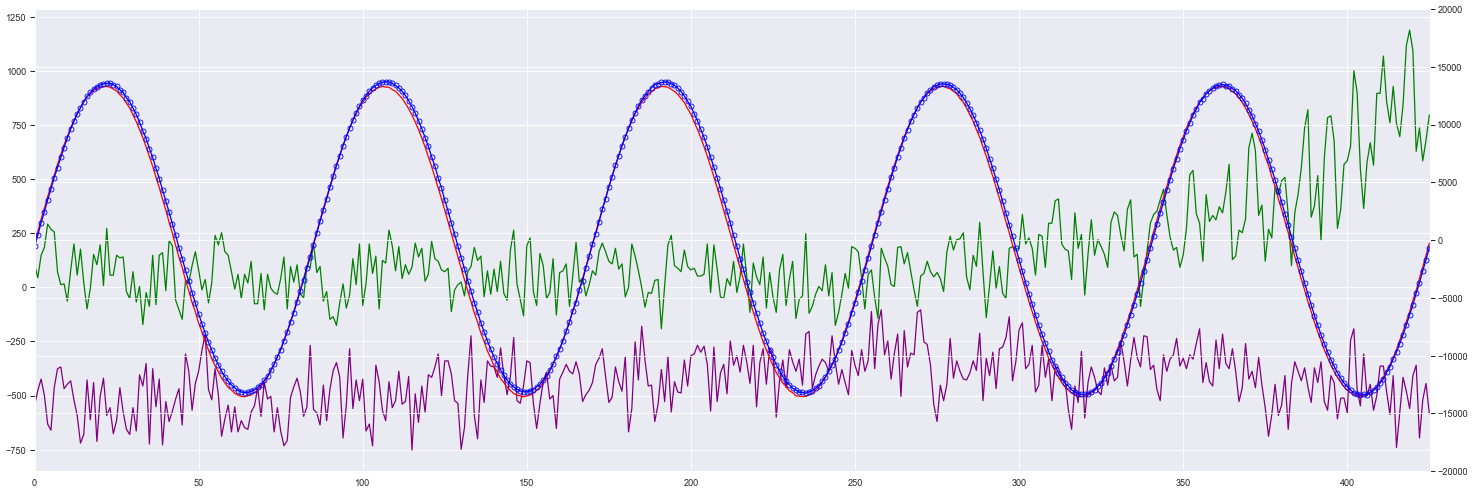

In [7]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(i, B[slice_start_data_B], color='green')
plt.plot(i, B[slice_last_data_B], color='purple')

plt.twinx()
plt.plot(i, RF[slice_start_data_RF], color='red')
plt.plot(i, RF[slice_last_data_RF], marker='o', color='blue', markerfacecolor='none')

plt.xlim([0, L_p])
plt.ylim([-2*10**(4), 2*10**4])


None

## RF data fiffing to the harmonic RF waveform from injection to intermidate flat top

In [8]:
def find_P_b_matrix(k_b, L_i): #  пока оставить -----
    P_b = np.zeros((3, 3))
    cos_vals = np.cos(k_b * np.arange(int(L_i) + 1))
    sin_vals = np.sin(k_b * np.arange(int(L_i) + 1))

    P_b[0, 0] = np.sum(cos_vals**2)
    P_b[0, 1] = np.sum(cos_vals * sin_vals)
    P_b[0, 2] = np.sum(cos_vals)
    P_b[1, 0] = P_b[0, 1]
    P_b[1, 1] = np.sum(sin_vals**2)
    P_b[1, 2] = np.sum(sin_vals)
    P_b[2, 0] = P_b[0, 2]
    P_b[2, 1] = P_b[1, 2]
    P_b[2, 2] = L_i + 1

    return P_b

In [9]:
def zero_crossing(V, q, ofset, L_st):
    n = ofset
    i = 0
    L_b = L_st

    r_list = []

    while n < (V.shape[0] - np.floor(L_b) - 1):

        k_b = 2 * np.pi / L_b * q # связано со временеи обората, длинна сгустка - bunch ## похоже на фазу 

        L = int(L_b)

        Y = np.zeros(3) # матрица гармоник от 0 до L 
        Y[0] = np.sum(V[n:n + L + 1] * np.cos(k_b * np.arange(L + 1)))
        Y[1] = np.sum(V[n:n + L + 1] * np.sin(k_b * np.arange(L + 1)))
        Y[2] = np.sum(V[n:n + L + 1])

        P = find_P_b_matrix(k_b, L)
        A = np.linalg.inv(P) @ Y.T # ----

        r = np.zeros(3) # матрица корреляций 
        r[1] = np.sqrt(A[0]**2 + A[1]**2) # амплитуда 
        r[0] = n + (1 / k_b * np.arctan2(A[0], -A[1])) # фаза 
        r[2] = A[2] # ----

        r_list.append(r)

        n = int(np.floor(r_list[i][0] + L_b)) # перечет офсета 

        L_b = 1 / 10 * (r_list[i][0] - r_list[i-10][0]) if i > 12 else L_b # перечсет периода для окна 

        i += 1

    return r_list


In [10]:
q = 5 # назвать лучше h - гармоника ВЧ

In [11]:
res = zero_crossing(RF, q, ofs_RF, L_p) # набор матриц корреляций 

In [12]:
r = np.array(res)

In [13]:
n = np.arange(len(r)-1)

In [14]:
st = np.array(list(map(lambda x: np.floor(x[0]), r[1:]))) # в какой-то степени нормировка амплитуды

In [15]:
C = 21096 # периметр в см 
c = 2.998 * 10**10
m_pn = 9.382 * 10**8

In [16]:
beta = np.array([C / (c * delta_T * (r[index+1][0] - r[index][0])) for index in n]) # Лоренс фактор 

gamma = 1 / np.sqrt(1 - beta**2) # Лоренс фактор 

E = (gamma - 1) * m_pn # Полная энергия 

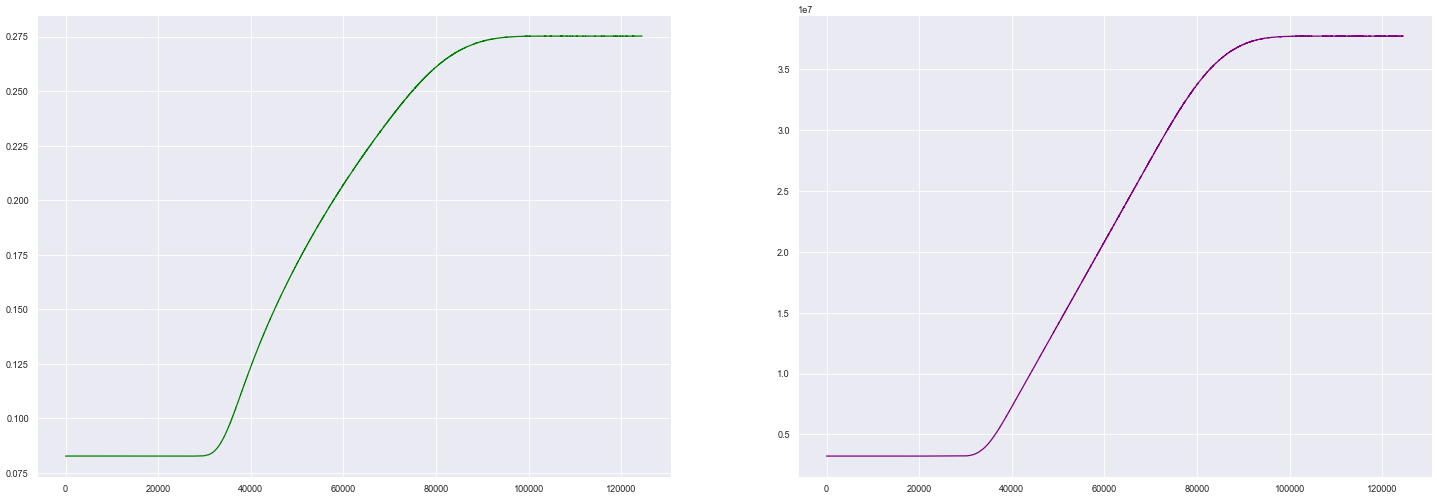

In [17]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.subplot(1,2,1)
plt.plot(n, beta, color='green')

plt.subplot(1,2,2)
plt.plot(n, E, color='purple')

None

In [18]:
r_difference = np.array([r[index+1][0] - r[index][0] for index in n]) # разность фаз ## изменение фазы ВЧ

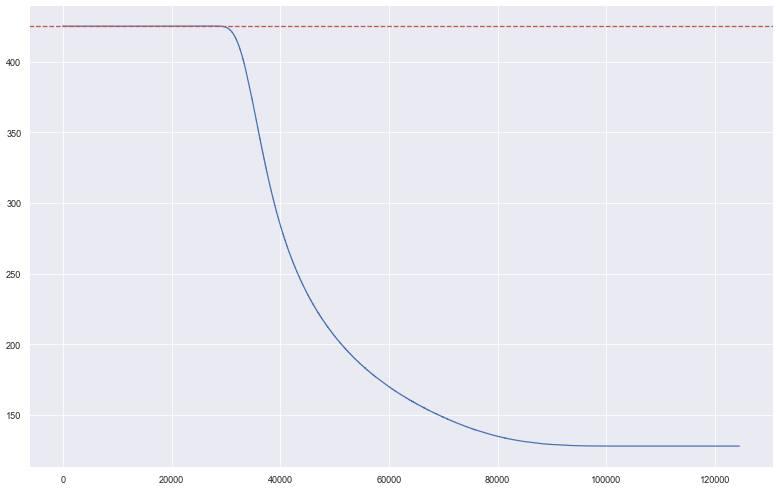

In [19]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(n, r_difference)

plt.axhline(y=L_p, color='r', ls='--')

None

In [20]:
nn = 60_000 # начало построения окна в отчетах для графика 
delta_iB = 10 # смещение для графика 

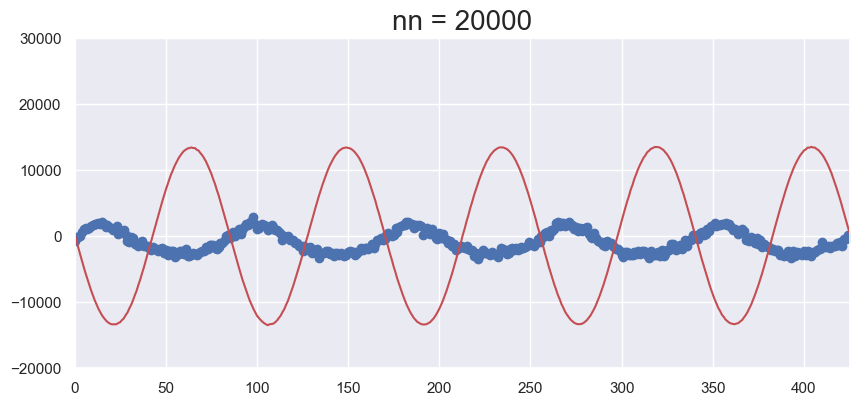

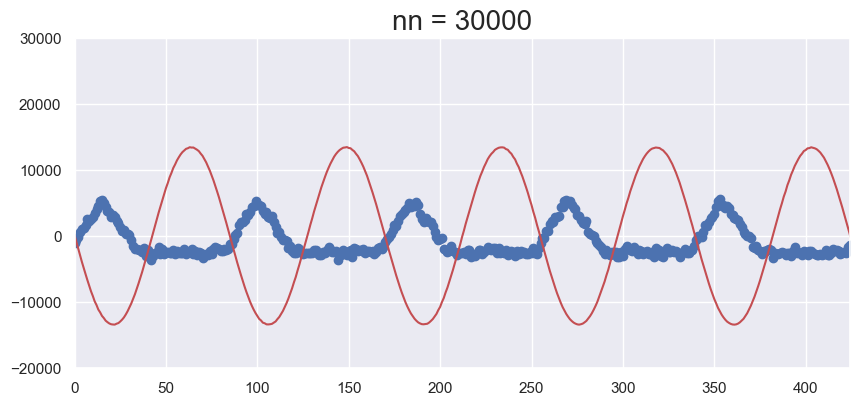

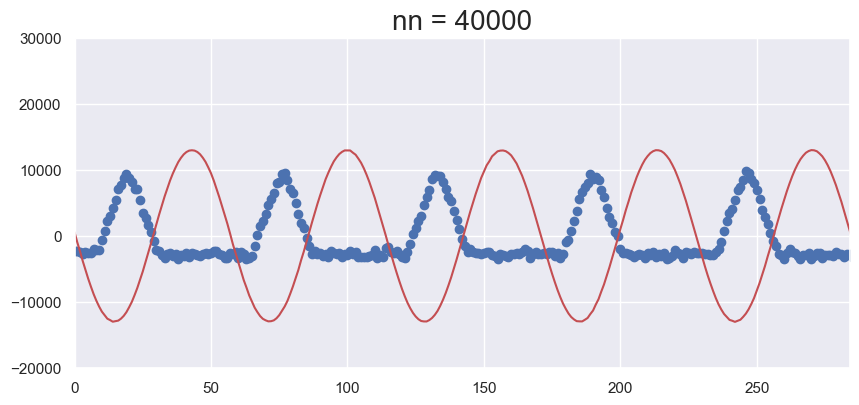

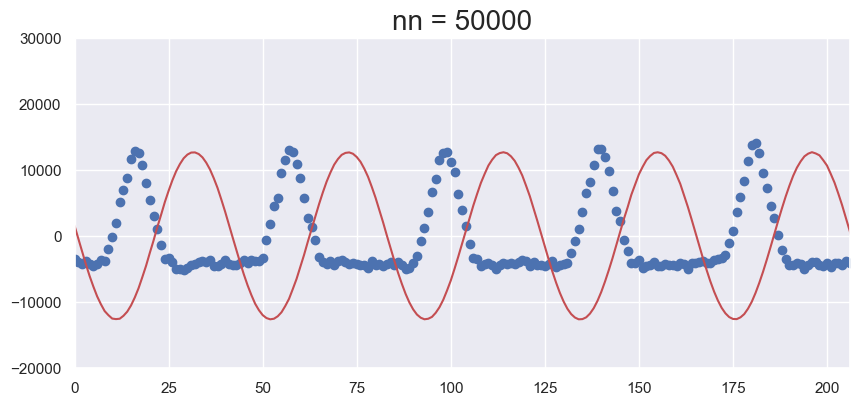

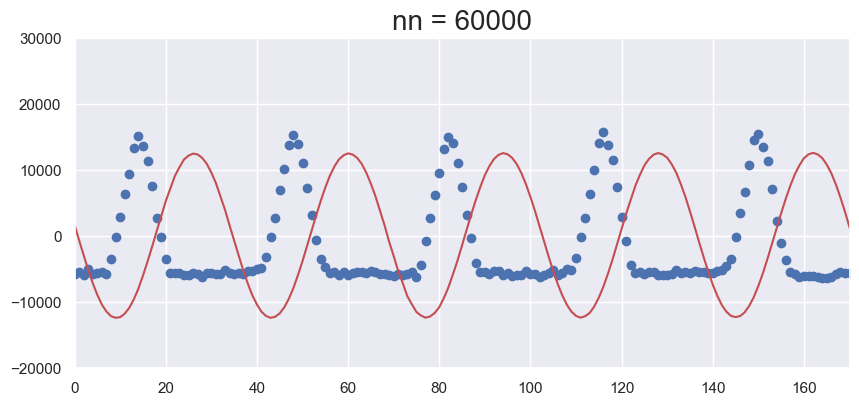

In [21]:
for nn in range(20_000, 70_000, 10_000):
    
    data_1 = RF[(i + st[nn]).astype(int)] - r[nn][2]
    data_2 = 3 * B[(i + st[nn] + delta_iB).astype(int)]


    plt.subplots(figsize=(10, 30))
    plt.subplot(6,1, nn // 10_000)
    
    plt.title(f'nn = {nn}', fontsize=20)
    plt.plot(i, data_1, color='r')
    plt.scatter(i, data_2)

    plt.xlim([0, st[nn+1]-st[nn]])
    plt.ylim([-2*10**4, 3*10**4])
    
    None

вопрос по поводу того, что фаза 10 к и 20 к отличается от основного сигнала 

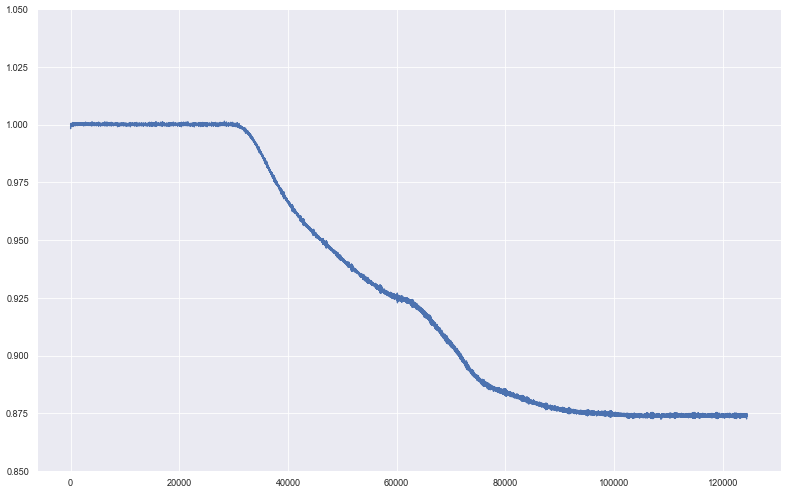

In [22]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(n, r[n,1] / r[0,1]) # нормировка фазы на начальную 

plt.ylim([0.85, 1.05])

None

In [23]:
N_avr = 6 # окно усреднения 

In [24]:
def get_minimum(U, L, ofs, N_avr): # сглаживание усреднием и поиск минимуна по усредненному сигналу 

    V = np.zeros(int(L)) # сглаживание усреднением 

    for i in range(int(L)):
        V[i] = 1 / (2 * N_avr + 1) * np.sum(U[int(i + ofs - N_avr): int(i + ofs + N_avr + 1)])
    
    r = np.min(V) 

    return r

In [25]:
n = np.arange(2, len(r)-2)

In [27]:
mn = [] # набор минимумов сглаженного сигнала 

for i in n:
    mn_n = get_minimum(B, st[i+1] - st[i], st[i] + delta_iB, N_avr)

    mn.append(mn_n)

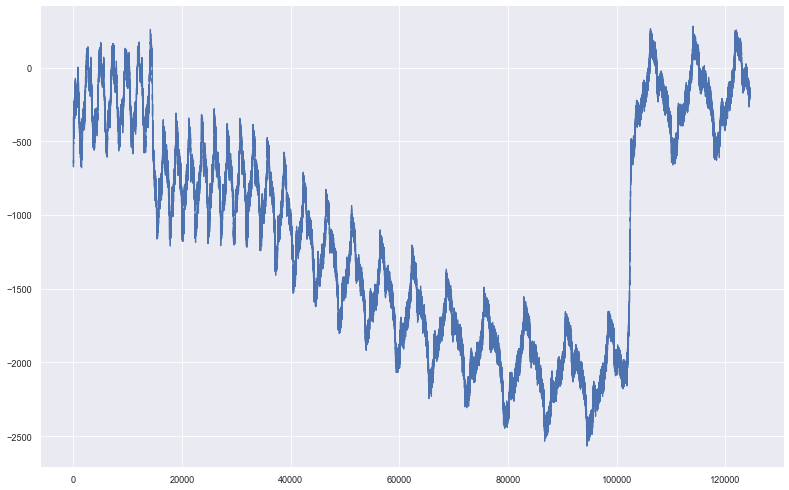

In [28]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(n, mn)

None

In [29]:
mn = np.array(mn)

In [30]:
N_ion = np.zeros(len(n)) # интенсивность пучка в частицах 

for i in n: 
    N_ion[i-2] = 8.6 * 10**(-5) * (10**(-3) / (5 * Z)) * (delta_T / e_SI) * np.sum(B[int(st[i] + delta_iB): int(st[i+1] + delta_iB + 1)] - mn[i-2])

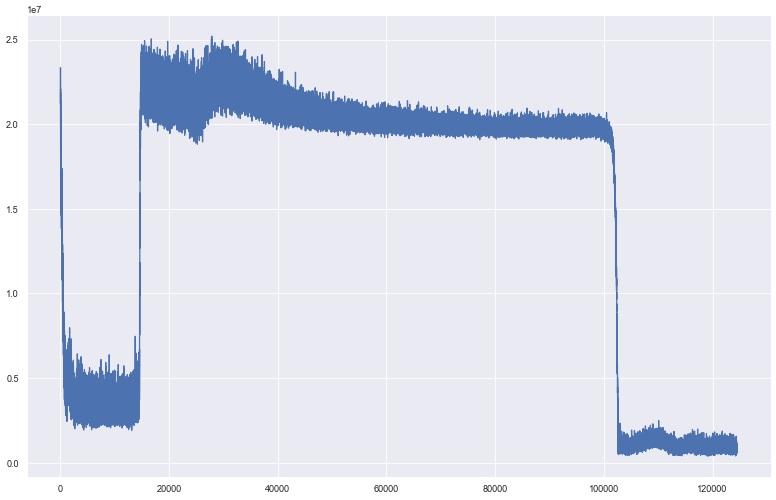

In [31]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(n, N_ion)

None

In [32]:
fi = np.zeros(len(n)) # фаза в градусах 

for i in n:
    up_sum = np.sum((B[int(st[i] + delta_iB): int(st[i+1] + delta_iB + 1)] - mn[i-2]) * (np.arange(st[i+1]-st[i]+1) + st[i] - (r[i+2, 0] + r[i+1, 0]) / 2))
    
    under_sum = np.sum(B[int(st[i] + delta_iB): int(st[i+1] + delta_iB + 1)] - mn[i-2])

    fi[i-2] = 360 * q / (st[i+1] - st[i]) * (up_sum / under_sum) # коэффициент поправки для выравнивания сигналов относительно нуля 

    # st[i+1] - st[i] - delta_fi 

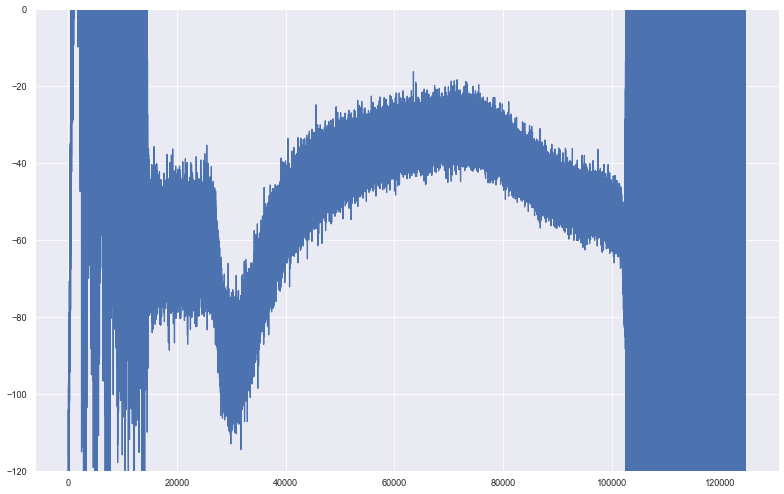

In [33]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(n, fi)

plt.ylim([-120, 0])

None

In [34]:
N_av = 20 # новое окно для усреднения 

n_a = np.arange(np.floor(len(r) / 20) - 1).astype(int)

In [35]:
fi_a = np.zeros(len(n_a)) # фильтрация фазы 
fi = np.hstack((np.zeros(2), fi)) 

for i in n_a:
    fi_a[i] = 1 / N_av * np.sum(fi[i * N_av:i * N_av + N_av])

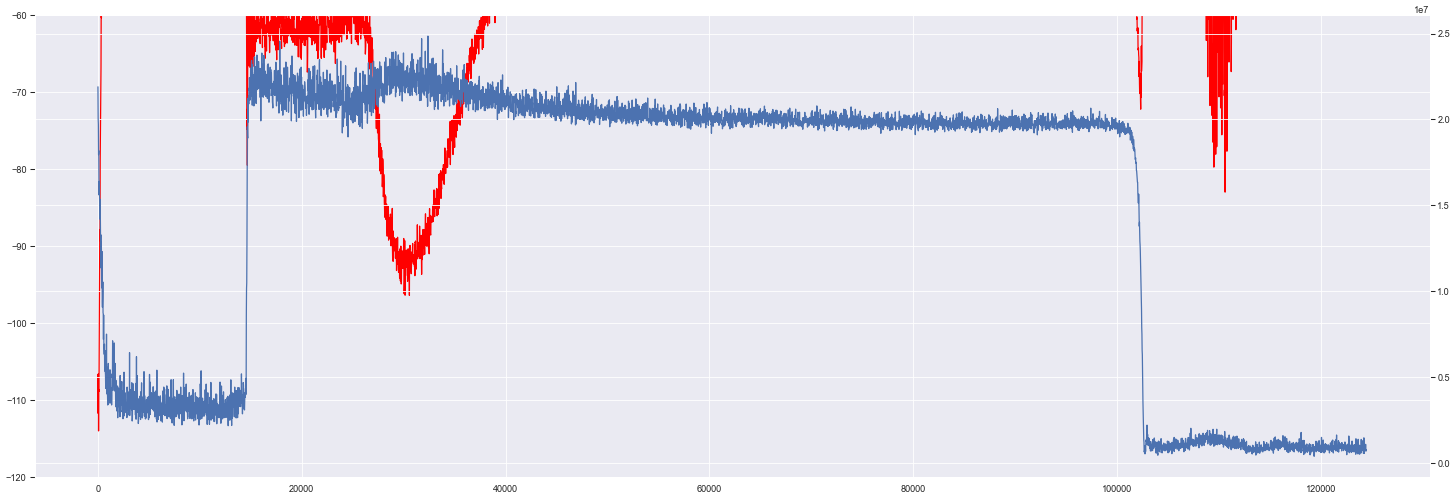

In [37]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(N_av * n_a, fi_a, color='red')

plt.ylim([-120, -60])

plt.twinx()
plt.plot(N_av * n_a, N_ion[n_a*N_av])


None

# N_av * n_a - учет усреднений для графиков 

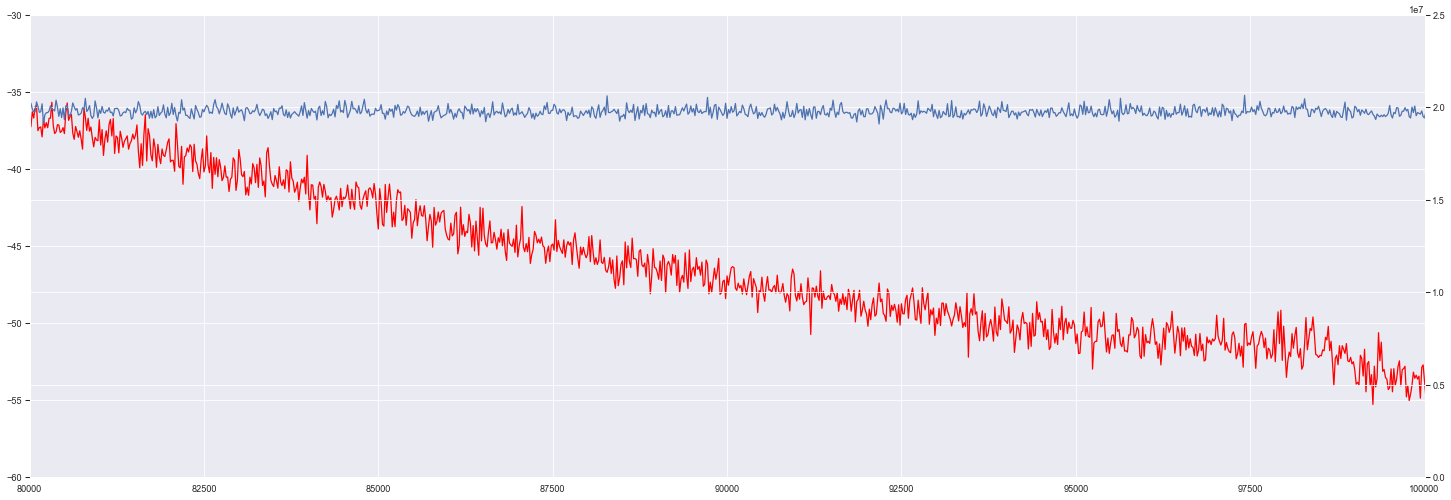

In [38]:
fig = plt.figure(figsize=(30, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(N_av * n_a, fi_a, color='red')

plt.ylim([-60, -30])
plt.xlim([8*10**4, 10**5])

plt.twinx()
plt.plot(N_av * n_a, N_ion[n_a*N_av])

plt.ylim([0, 2.5*10**7])

None

# **Data writing**

In [76]:
file_name = r'BoosterAcceleration1_1half.dat'

In [74]:
O = np.dstack((r[2:-2,0], N_ion, fi[2:]))

In [77]:
with open(file_name, "wb") as file:
    np.save(file, O)